In [19]:
import cv2
import torch
import numpy as np
import torch.nn.functional as F
from torchvision import transforms
from models import PerformanceModel
from emotionoverlay import EmotionOverlay  # Import EmotionOverlay



In [20]:
# Load the trained PyTorch model (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "model/ferplus_model_pd_acc.pth"
model = PerformanceModel(input_shape=(1, 48, 48), n_classes=8, logits=True).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

#Emotion categories (Order must match training data)
emotions = ["Neutral", "Happy", "Surprise", "Sad", "Angry", "Disgust", "Fear", "Contempt"]

#OpenCV face detector
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
vid = cv2.VideoCapture(0)  # Start webcam

# Optimized Preprocessing Pipeline (No PIL conversion, Faster NumPy)
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Resize((48, 48)),  # Resize directly
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])




In [21]:
emotion_text_colors = {
    "Neutral": [(255,255,255), (224,212,196), (228,203,179)],
    "Happy": [(182,110,68), (76,235,253), (83,169,242)],
    "Surprise": [(247,255,0), (42,42,165), (232,206,0)],
    "Sad": [(194,105,3), (228,172,32), (237,202,162)],
    "Angry": [(61, 57, 242), (49,121,249), (232,220,214)],
    "Disgust": [(70,190,77), (120,159,6), (100,55,124)],
    "Fear": [(198, 128, 134), (133,71,68), (80,45,98)],
    "Contempt": [(160, 134, 72), (145, 180, 250), (173, 217, 251)]
}
color_index = 0  # Track which color is active


In [22]:
emotion_colors = {
    "Neutral": (255, 255, 255),  # White
    "Happy": (0, 255, 255),  # Yellow
    "Surprise": (0, 165, 255),  # Orange
    "Sad": (255, 0, 0),  # Blue
    "Angry": (0, 0, 255),  # Red
    "Disgust": (128, 0, 128),  # Purple
    "Fear": (255, 255, 0),  # Cyan
    "Contempt": (0, 255, 0)  # Green
}

In [23]:
#Load EmotionOverlay
overlay = EmotionOverlay("emojiImages/")  # Ensure correct folder path

print("Model & Face Detector Loaded! Starting Webcam...")

# Track total emotion scores
emotion_totals = {emotion: 0.0 for emotion in emotions}

# Track emotion scores over time
emotion_over_time = {emotion: [] for emotion in emotions}
frame_timestamps = []  # Optional: use for X-axis (like frame number)

frame_count = 0  # To control face detection frequency
animation_offset = 0  # For floating animation
offset_direction = 1  # To make it go up/down



Model & Face Detector Loaded! Starting Webcam...


In [24]:
while True:
    ret, frame = vid.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Change color every 10 frames
    if frame_count % 10 == 0:  
        color_index = (color_index + 1) % 3  # Cycle through 3 colors

    #Run face detection only every 3 frames (to reduce lag)
    if frame_count % 3 == 0:
        faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(48, 48))
    frame_count += 1
    

    for (x, y, w, h) in faces:
        face_img = gray[y:y + h, x:x + w]  # Extract face
        face_img = cv2.resize(face_img, (48, 48))  # Resize directly with OpenCV (faster than PIL)
        face_img = np.expand_dims(face_img, axis=0)  # Add channel dimension (1,48,48)
        face_tensor = torch.tensor(face_img, dtype=torch.float32).div(255).sub(0.5).div(0.5).unsqueeze(0).to(device)

        #Run model inference
        with torch.no_grad():
            outputs = model(face_tensor)
            probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
            top_emotion_idx = np.argmax(probs)
            top_emotion = emotions[top_emotion_idx]
            for i, emotion in enumerate(emotions):
                emotion_totals[emotion] += probs[i]
                emotion_over_time[emotion].append(probs[i])
            frame_timestamps.append(frame_count)

        #Floating animation logic
        animation_offset += offset_direction * 2  # Move up/down by 2 pixels
        if abs(animation_offset) > 10:
            offset_direction *= -1  # Reverse direction

        #Overlay character
        frame = overlay.overlay_image(frame, top_emotion, x, y, w, h, animation_offset)

        #Draw rectangle around face
        box_color = emotion_colors.get(top_emotion, (255, 255, 255))  # Default to white if not found
        cv2.rectangle(frame, (x, y), (x + w, y + h), box_color, 2)  # Draw box with emotion color


        #Display emotions (Top emotion gets its unique color)
        for i, (emotion, prob) in enumerate(zip(emotions, probs)):
            # Use cycling color for the top emotion, default white for others
            if i == top_emotion_idx:
                text_color = emotion_text_colors[top_emotion][color_index]  # Cycle colors
            else:
                text_color = (255, 255, 255)  # Keep other text white

            text = f"{emotion}: {int(prob * 100)}%"
            cv2.putText(frame, text, (x, y - 10 - (i * 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)


    cv2.imshow("Facial Emotion Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vid.release()
cv2.destroyAllWindows()

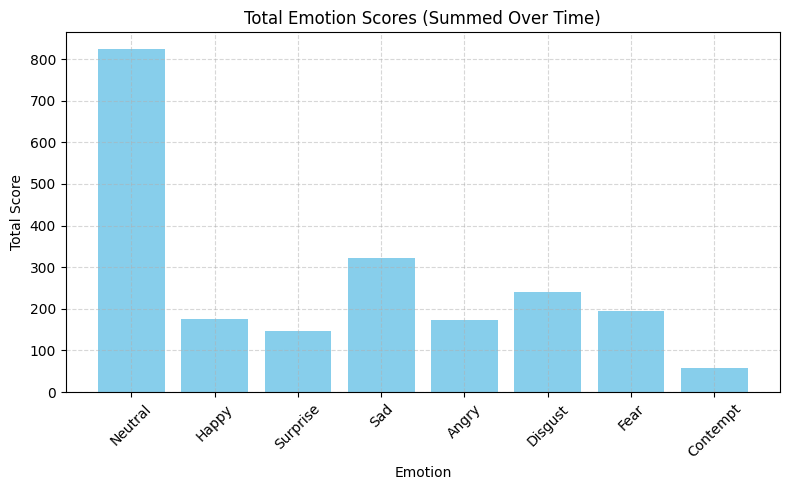

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(emotion_totals.keys(), emotion_totals.values(), color='skyblue')
plt.title("Total Emotion Scores (Summed Over Time)")
plt.xlabel("Emotion")
plt.ylabel("Total Score")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


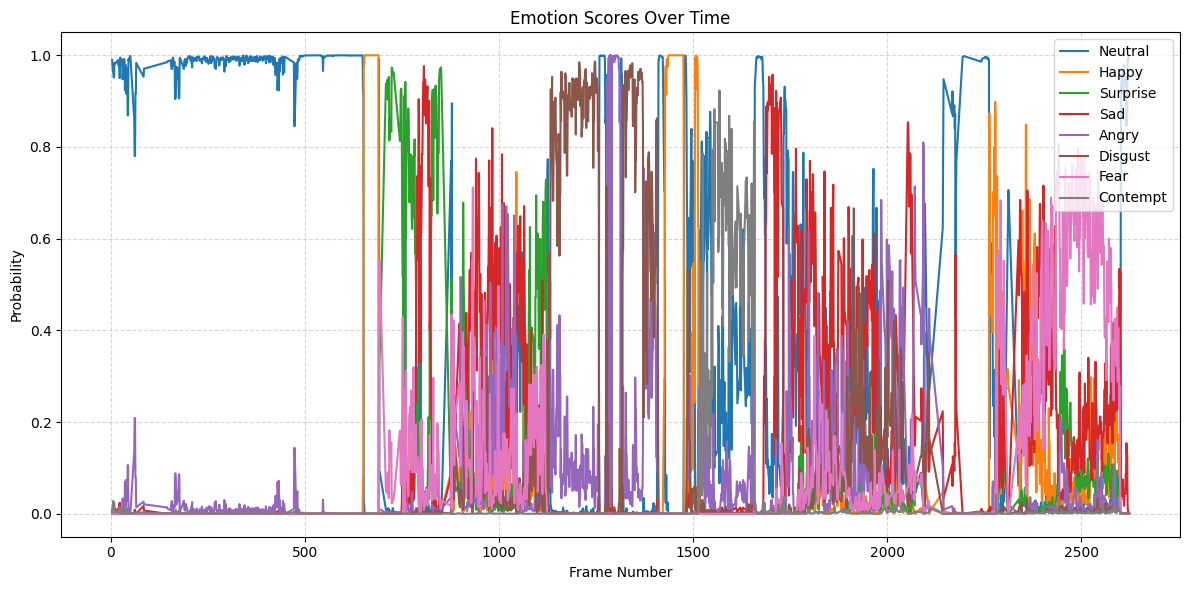

In [26]:
plt.figure(figsize=(12, 6))
for emotion, scores in emotion_over_time.items():
    plt.plot(frame_timestamps, scores, label=emotion, linewidth=1.5)

plt.title("Emotion Scores Over Time")
plt.xlabel("Frame Number")
plt.ylabel("Probability")
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
